# Dominos - Sales forecasting and Purchse Order System

## 1. Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings

# Suppressing the  warnings
warnings.filterwarnings("ignore")

c:\Users\DELL\anaconda3\envs\py12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Importing the Data

In [2]:
Sales_dataset = pd.read_excel("data/Pizza_Sale.xlsx")
Ingredients_dataset = pd.read_excel("data/Pizza_ingredients.xlsx")

## 3. Understanding the Data
* On average, a Domino's store in US sells about 400 pizzas per day. Domino's US sells over 4 million pizzas per month.

### Dataset Overview:
* Pizza_Sale.csv with 48,620 rows and 12 columns.
* Pizza_Ingredients.csv with 518 rows and 4 columns.

## a) Sales Data

In [3]:
Sales_dataset.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
Sales_dataset.info()
print('\nShape of the sales data:', Sales_dataset.shape)
print('\nstatistics of sales data:\n', Sales_dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB

Shape of the sales data: (48620, 12)

statistics of sales data:
            pizza_id      order_id      quantity    unit_price   total_price
count  48620.00

## 4. Handling Missing Values

In [5]:
## Missing Values in Sales Data

Sales_dataset.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [6]:
# Filling Total Price Based on Quantity

Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)

In [7]:
# Filling Missing Pizza Categories Based on Pizza Name ID

Sales_dataset['pizza_category'].value_counts()

pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
Name: count, dtype: int64

In [8]:
Sales_dataset[Sales_dataset['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,2015-03-01 00:00:00,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,2015-03-01 00:00:00,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,2015-03-01 00:00:00,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,2015-03-01 00:00:00,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,2015-03-01 00:00:00,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [9]:
Sales_dataset['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1358
four_cheese_l     1272
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [10]:
category_mapping = Sales_dataset[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales_dataset['pizza_category'] = Sales_dataset['pizza_category'].fillna(Sales_dataset['pizza_name_id'].map(category_mapping))

In [11]:
# Filling Missing Pizza Ingredients Based on Pizza Name

Sales_dataset[Sales_dataset['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,2015-04-01 00:00:00,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,2015-05-01 00:00:00,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,2015-05-01 00:00:00,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [12]:
# Mapping Pizza Name to Fill Pizza Ingredients

ingredients_mapping = Sales_dataset[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales_dataset['pizza_ingredients'] = Sales_dataset['pizza_ingredients'].fillna(Sales_dataset['pizza_name'].map(ingredients_mapping))

In [13]:
## Filling Missing Pizza Name Based on Pizza Ingredients:
### Mapping Pizza Ingredients to Fill Pizza Name

Sales_dataset[Sales_dataset['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,2015-05-01 00:00:00,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,2015-05-01 00:00:00,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,2015-05-01 00:00:00,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,2015-05-01 00:00:00,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,2015-05-01 00:00:00,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,2015-05-01 00:00:00,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,2015-05-01 00:00:00,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [14]:
len(Sales_dataset['pizza_ingredients'].value_counts())

32

In [15]:
ingredients_name_mapping = Sales_dataset[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_dataset['pizza_name'] = Sales_dataset['pizza_name'].fillna(Sales_dataset['pizza_ingredients'].map(ingredients_name_mapping))

In [16]:
# Filling Missing Pizza Name ID Based on Pizza Name

name_id_mapping = Sales_dataset[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

# Mapping Pizza Name to Fill Pizza Name ID

Sales_dataset['pizza_name_id'] = Sales_dataset['pizza_name_id'].fillna(Sales_dataset['pizza_name'].map(name_id_mapping))

In [17]:
# Verifing the Changes

Sales_dataset.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

## b) Ingredients Data

In [18]:
Ingredients_dataset.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [19]:
Ingredients_dataset.info()
print('\nShape of the ingredients data:', Ingredients_dataset.shape)
print('\nstatistics of ingredients data:\n', Ingredients_dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB

Shape of the ingredients data: (518, 4)

statistics of ingredients data:
        Items_Qty_In_Grams
count          514.000000
mean            30.564202
std             30.351623
min              5.000000
25%             10.000000
50%             20.000000
75%             40.000000
max            200.000000


In [20]:
# Handling Missing Values in Ingredients Data

Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [21]:
Ingredients_dataset[Ingredients_dataset['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [22]:
Ingredients_dataset[Ingredients_dataset['pizza_name']=='The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [23]:
Ingredients_dataset[Ingredients_dataset['pizza_ingredients']=='Sliced Ham']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [24]:
Ingredients_dataset[Ingredients_dataset['pizza_name_id']=='hawaiian_l']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0


In [25]:
# Calculateing the Mean for each Pizza Name ID

mean_qty = Ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

In [26]:
# Filling missing Items Quantity values using the Mean value

Ingredients_dataset['Items_Qty_In_Grams'] = Ingredients_dataset['Items_Qty_In_Grams'].fillna(Ingredients_dataset['pizza_name_id'].map(mean_qty))

In [27]:
# Checking for remaining missing values in Items_Qty_In_Grams

remaining_missing_qty = Ingredients_dataset['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [28]:
Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

## 5. Merging Sales and Ingredients DataFrames

In [29]:
merged_data = pd.merge(Sales_dataset, Ingredients_dataset, on='pizza_name_id', how='left')

In [30]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [31]:
merged_data.shape

(267576, 15)

In [32]:
merged_data.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [33]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [34]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [35]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [36]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [37]:
merged_data.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

In [38]:
merged_data.duplicated().sum()

80204

In [39]:
# Droping duplicate rows from the dataset
merged_data = merged_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [40]:
merged_data1 = merged_data.copy()

In [41]:
# Summary statistics
merged_data.describe()

,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,16.914338,17.244843,37.645900
std,14039.560378,6181.841091,0.141575,3.571451,4.419979,35.729459
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [42]:
# Checking the data types and column names
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB


## 6. Feature Exploration and Engineering
### Converting Order Dates to DateTime

In [43]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [44]:
# Extracting the day of the week
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek # day_name()
# Extracting the month
merged_data['month'] = merged_data['order_date'].dt.month # month_name()
# Createing a new column for the week number
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
# Extracting the year
merged_data['year'] = merged_data['order_date'].dt.year

### Adding Holiday Indicator to the Data

In [45]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [46]:
import holidays

# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

# Checking if the holiday flag works
merged_data[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1


In [47]:
merged_data[['order_date', 'holiday']].tail()

,order_date,holiday
267565,2015-12-31,0
267567,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0
267573,2015-12-31,0


### Adding Weekend Promotion Flag (assuming promotions happen on weekends)

In [48]:
# Creating a 'promotional_period' flag for weekends 
merged_data['promotion'] = merged_data['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_data[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
6,2015-01-01,0


In [49]:
merged_data[merged_data['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
910,2015-02-01,1
911,2015-02-01,1
914,2015-02-01,1
917,2015-02-01,1
918,2015-02-01,1


In [50]:
merged_data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
promotion             0
dtype: int64

In [51]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0


In [52]:
# Aggregateing sales data by date
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()

# daily_sales.set_index('order_date', inplace=True)
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


### Train-Test Split

In [53]:
# Preparing the Data for Time Series Forecasting
# Converting order_date to datetime format

import pandas as pd

merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])

merged_data = merged_data.set_index('order_date').sort_index()

daily_sales = merged_data['total_price'].resample('D').sum()

print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187372, 18)


In [54]:
# Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_data[merged_data['week'] == 7]

# Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 299 pizzas
The Big Meat Pizza: 96 pizzas
The Brie Carre Pizza: 32 pizzas
The Calabrese Pizza: 88 pizzas
The California Chicken Pizza: 226 pizzas
The Chicken Alfredo Pizza: 133 pizzas
The Chicken Pesto Pizza: 64 pizzas
The Classic Deluxe Pizza: 132 pizzas
The Five Cheese Pizza: 58 pizzas
The Four Cheese Pizza: 181 pizzas
The Greek Pizza: 141 pizzas
The Green Garden Pizza: 78 pizzas
The Hawaiian Pizza: 105 pizzas
The Italian Capocollo Pizza: 132 pizzas
The Italian Supreme Pizza: 148 pizzas
The Italian Vegetables Pizza: 59 pizzas
The Mediterranean Pizza: 73 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 68 pizzas
The Pepper Salami Pizza: 80 pizzas
The Pepperoni Pizza: 98 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 33 pizzas
The Prosciutto and Arugula Pizza: 71 pizzas
The Sicilian Pizza: 176 pizzas
The Soppressata Pizza: 68 pizzas
The Southwest Chicken Pizza: 170 pizzas
The Spicy Italian Pizza: 161 pizzas
The Spinach Pe

## 7. Exploratory Data Analysis (EDA) - Visualizing Distributions
### i) Analyzing Sales Trends Over Time

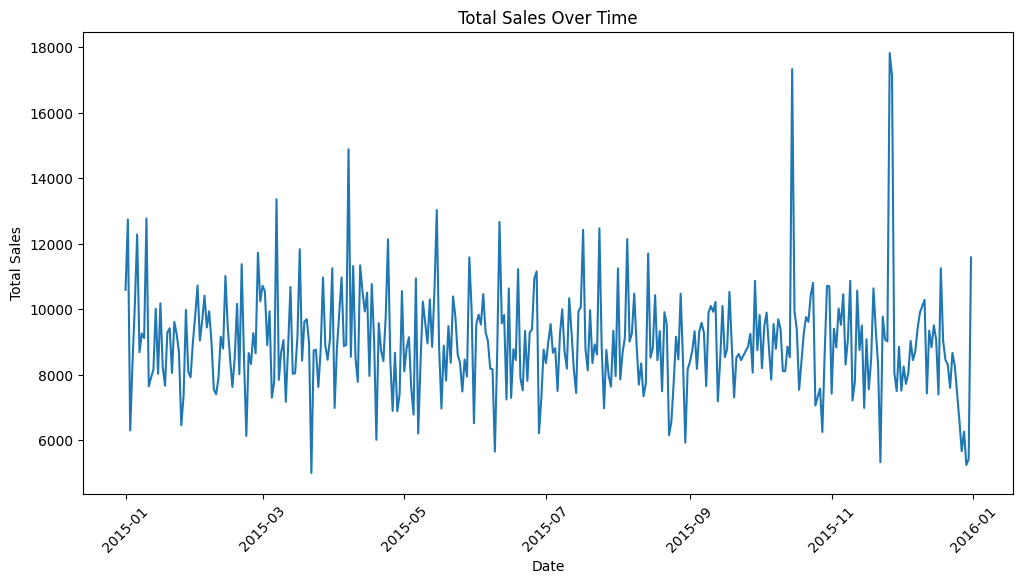

In [55]:
# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

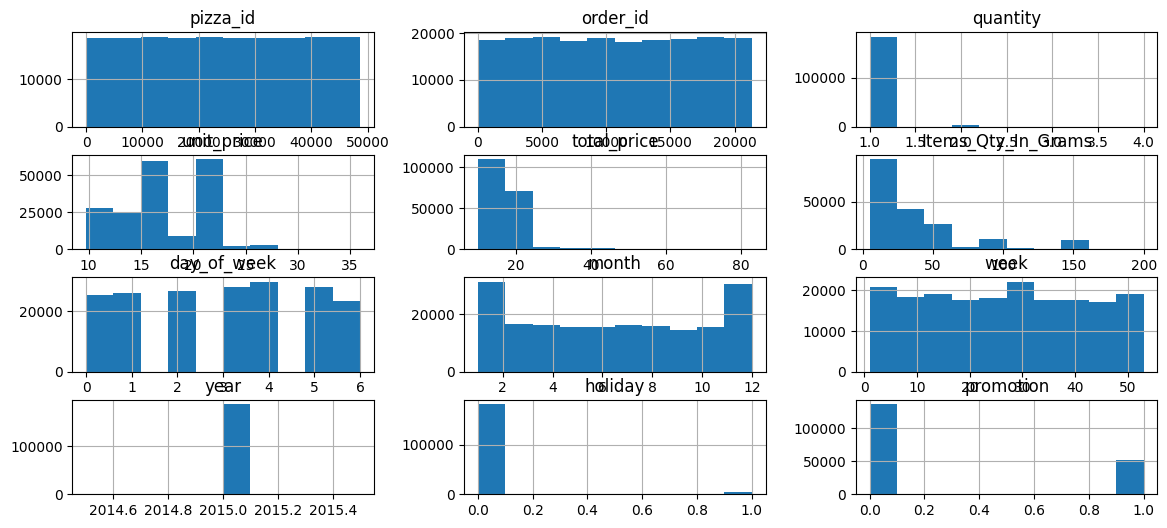

In [56]:
merged_data.hist(figsize=(14,6))
plt.show()

### ii) Top-Selling Pizzas

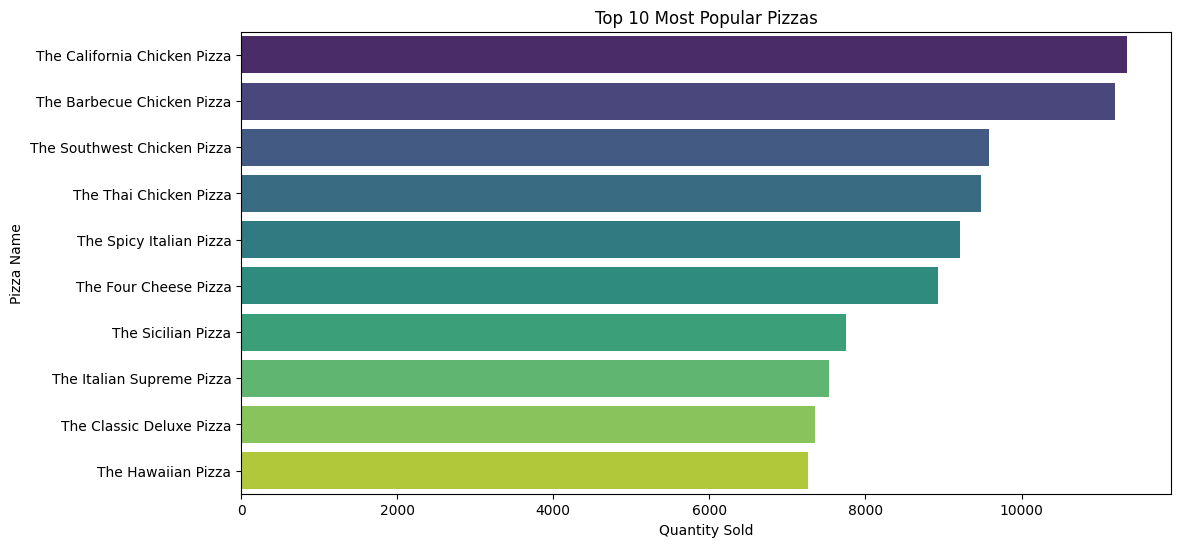

In [57]:
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

### iii) Sales by Pizza Size

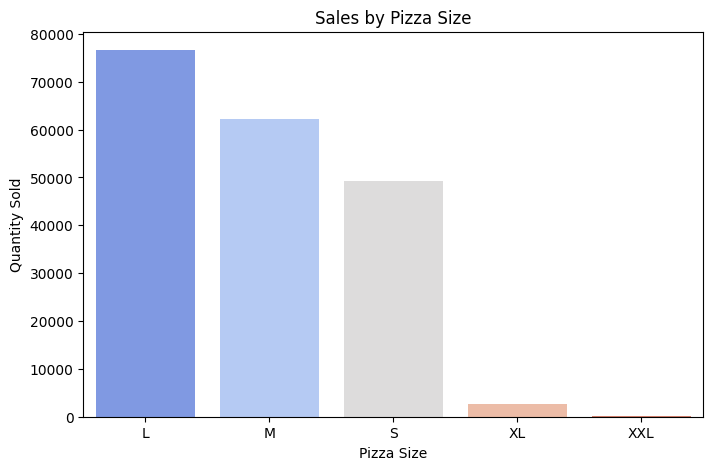

In [58]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

### iv) Sales by Pizza Category

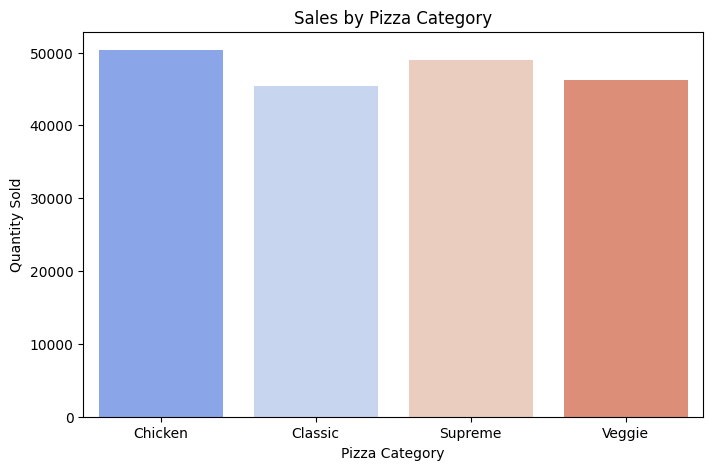

In [59]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

### v) Seasonal Sales Trends and Patterns

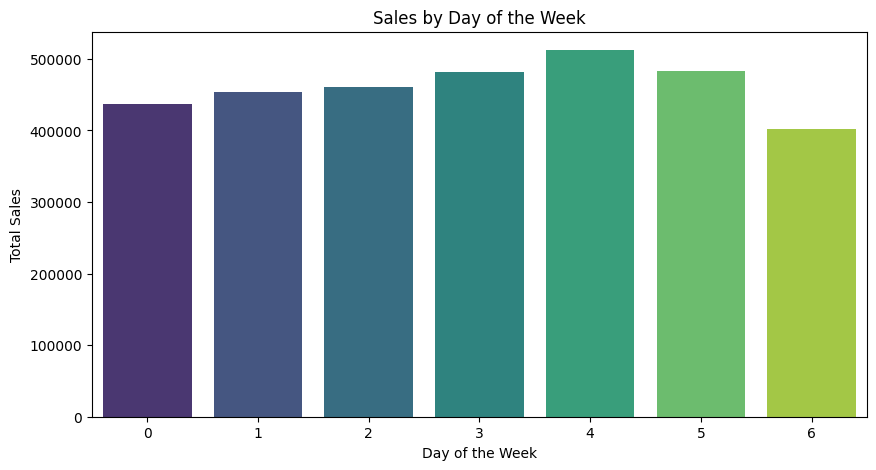

In [60]:
# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

### vi) Sales by Month

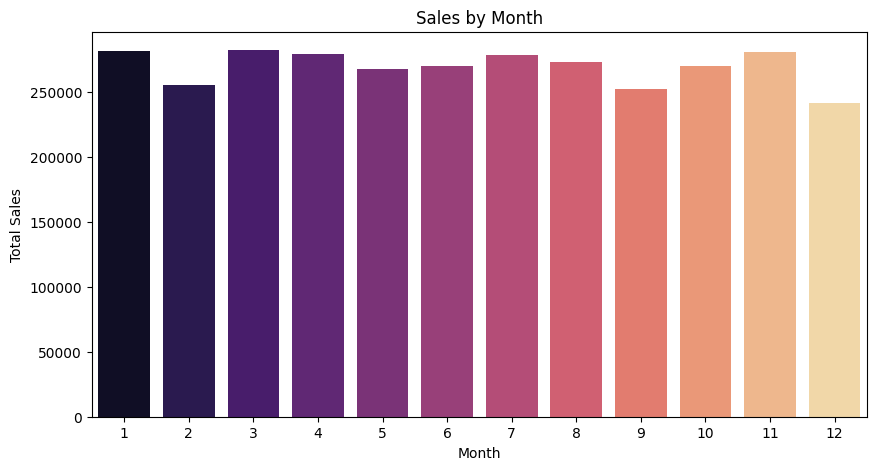

In [61]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

### vii) Correlation Analysis of Sales Metrics

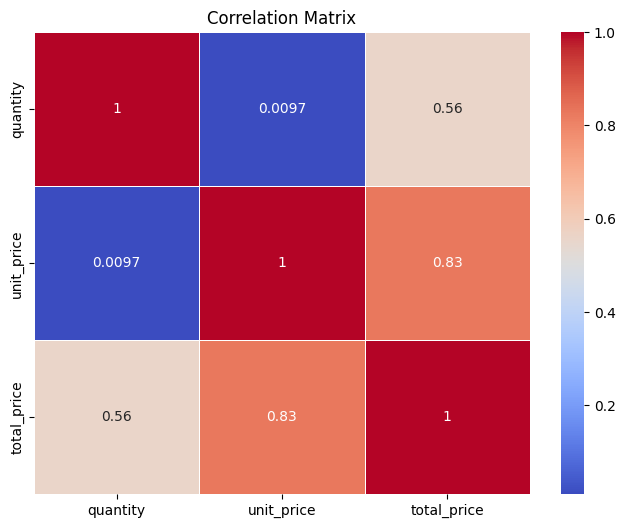

In [62]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### viii) Outlier Detection in Sales Data

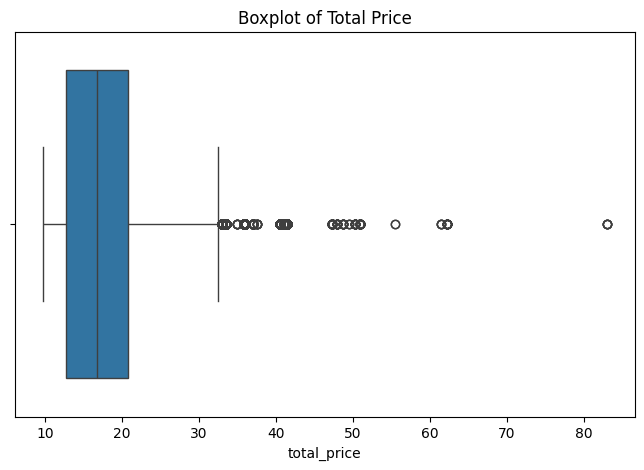

In [63]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

### ix) Sales during holidays vs non-holidays

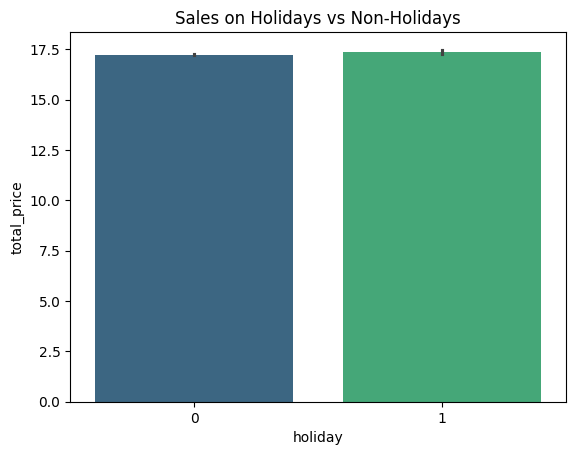

In [64]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

### x) Sales during promotions vs non-promotions

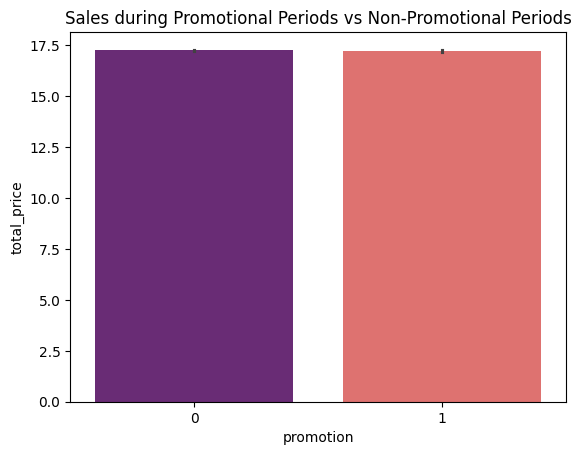

In [65]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()